<a href="https://colab.research.google.com/github/Jaehwi-So/DeepLearning_Study/blob/main/DL04_CNN2_ResNet_CIFAR%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR(Canadian Institute for Advanced Research)
- 기계 학습 및 컴퓨터 비전 분야에서 널리 사용되는 이미지 분류를 위한 데이터셋
- CIFAR-10은 10개의 클래스(예: 비행기, 자동차, 새 등)로 구성된 60,000개의 32x32 컬러 이미지를 포함
- CIFAR-100은 100개의 클래스로 구성된 동일한 크기의 이미지를 포함

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import os

%load_ext autoreload
%autoreload 2

os.chdir('drive/MyDrive/DL2024_201810776/week10')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CIFAR 데이터 로드 및 전처리


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Layer, AveragePooling2D, Input, BatchNormalization, ReLU,  Add, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [14]:
from tensorflow.keras.datasets import cifar10

# 데이터 로드 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255 #0~255 정규화
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### 데이터의 크기
- Input Data의 Shape는 32X32X3

In [15]:
x_train.shape

(50000, 32, 32, 3)

# ResNet34 모델 만들기
- 직접 ResNet34의 Layer를 구성해서 모델을 생성해보자.
- 총 컨볼루션 연산 실행 횟수 : 36회
1. 초기 컨볼루션 Layer : 1회
2. 64 Filter Layer : 3 x 2 = 6회
3. 128 Filter Layer : 4 x 2 + 1(shortcut) = 9회
4. 256 Filter Layer : 6 x 2 + 1(shortcut) = 13회
5. 512 Filter Layer : 3 x 2 + 1(shortcut) = 7회

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Layer, AveragePooling2D, Input, BatchNormalization, ReLU,  Add, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

def residual_block(x, filters, stride=1):
    shortcut = x

    # 첫 번째 컨볼루션
    x = Conv2D(filters, 3, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 두 번째 컨볼루션
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut 연결
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet34(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 초기 컨볼루션 레이어
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual 블록
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    # 평균 풀링 및 밀집층
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # 모델 구성
    model = Model(inputs=inputs, outputs=x)
    return model

# 모델 학습
- 다중 카테고리 분류이므로 Categorical Cross Entropy를 Loss로 사용한다
- Optimizer로는 ADAM을 사용한다.

In [22]:
model = build_resnet34((32, 32, 3), 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #adam

In [23]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 16, 16, 64)           9472      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_72 (Ba  (None, 16, 16, 64)           256       ['conv2d_72[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_66 (ReLU)             (None, 16, 16, 64)           0         ['batch_normalization_72

In [24]:
model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.1)

Epoch 1/20
352/352 [==============================] - 149s 62ms/step - loss: 1.5190 - accuracy: 0.4599 - val_loss: 2.5403 - val_accuracy: 0.2354
Epoch 2/20
352/352 [==============================] - 21s 58ms/step - loss: 1.0879 - accuracy: 0.6126 - val_loss: 1.3812 - val_accuracy: 0.5130
Epoch 3/20
352/352 [==============================] - 20s 58ms/step - loss: 0.9227 - accuracy: 0.6766 - val_loss: 1.8749 - val_accuracy: 0.4850
Epoch 4/20
352/352 [==============================] - 20s 57ms/step - loss: 0.7835 - accuracy: 0.7258 - val_loss: 1.6271 - val_accuracy: 0.5264
Epoch 5/20
352/352 [==============================] - 21s 59ms/step - loss: 0.6738 - accuracy: 0.7661 - val_loss: 1.2822 - val_accuracy: 0.5680
Epoch 6/20
352/352 [==============================] - 20s 58ms/step - loss: 0.5981 - accuracy: 0.7909 - val_loss: 1.0986 - val_accuracy: 0.6388
Epoch 7/20
352/352 [==============================] - 21s 60ms/step - loss: 0.5363 - accuracy: 0.8114 - val_loss: 0.9936 - val_accuracy

# Test Set에 대한 예측 및 모델 검증

In [25]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy:.3f}')

313/313 [==============================] - 4s 11ms/step - loss: 1.1489 - accuracy: 0.7362
Test accuracy: 0.736


In [27]:
# 예측
y_pred = model.predict(x_test)
y_pred = np.array(y_pred)

313/313 [==============================] - 3s 9ms/step


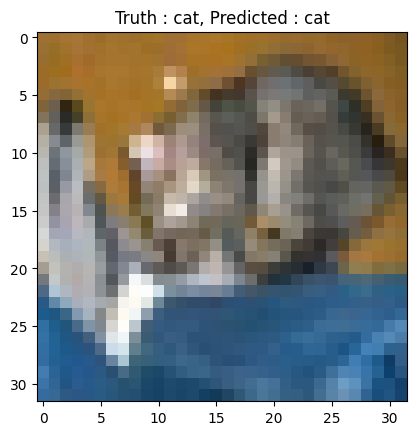

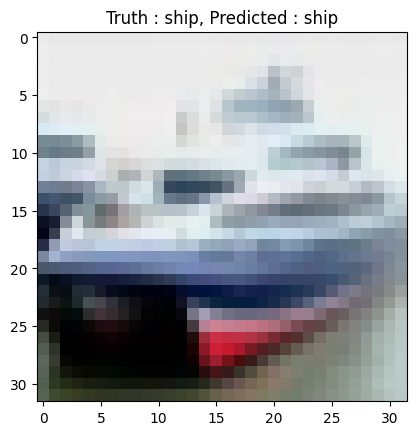

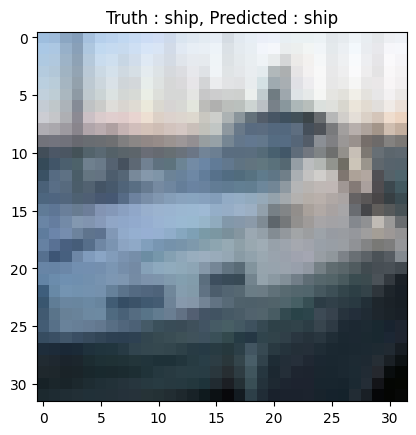

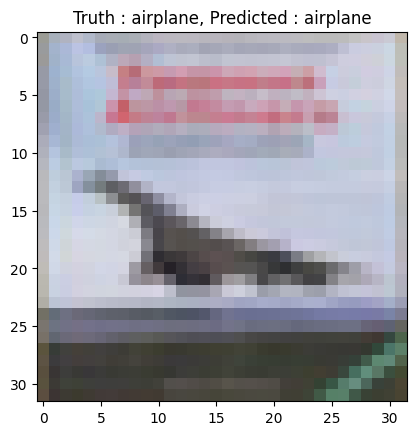

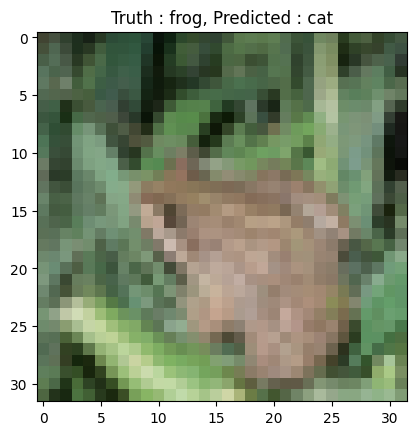

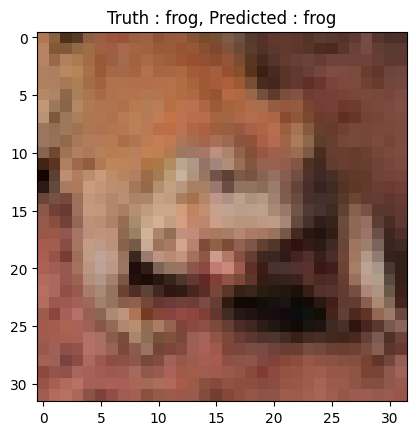

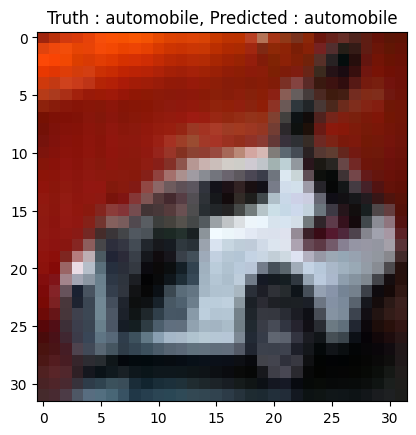

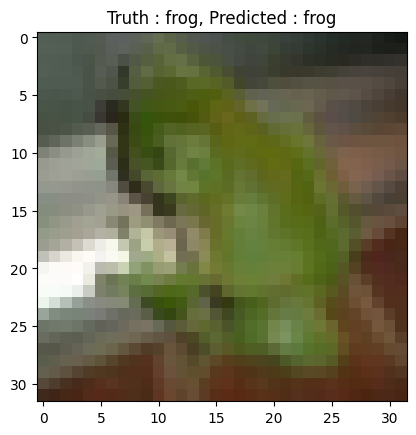

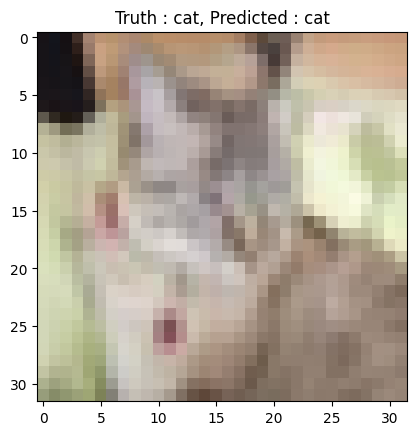

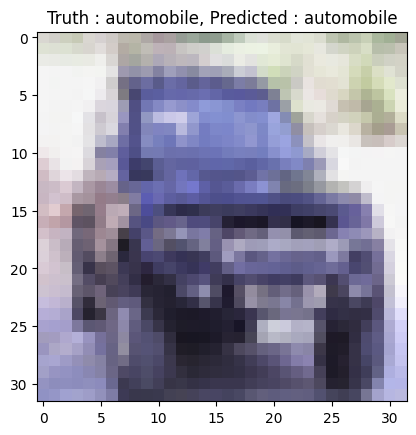

In [28]:
cifar10 = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

for idx in range(len(y_pred[:10])):
  plt.title("Truth : {}, Predicted : {}".format(cifar10[np.argmax(y_test[idx])], cifar10[np.argmax(y_pred[idx])]))
  plt.imshow(x_test[idx], cmap='gray')
  plt.show()

<br><hr><hr><br>

# 학습된 ResNet101 사용해보기
이번에는 학습이 완료된 ResNet101 모델을 사용해서 동물 이미지가 무엇인지 예측해보자.

In [30]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np

# 이미지 파일 불러오기
img_path = 'images/cat_224x224.jpg'  # 이미지 경로 설정
img = image.load_img(img_path, target_size=(224, 224))  # 모델에 맞는 이미지 크기로 조정

# 이미지를 배열로 변환하고 전처리
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


### 우리는 해당 고양이 사진을 예측할 것이다.

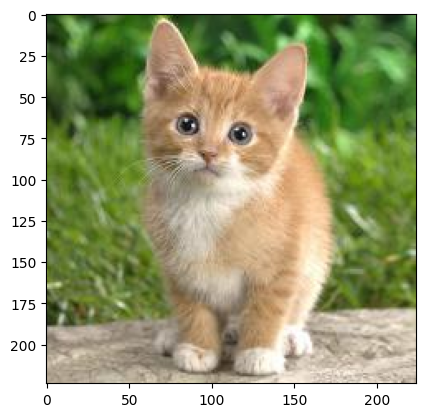

In [36]:
plt.imshow(img)

# ResNet101 모델 불러오기

In [37]:
# 모델 불러오기
model = ResNet101(weights='imagenet')

179648224/179648224 [==============================] - 2s 0us/step


# 예측
- tiger_cat일 확률이 43%, Egyptian_cat일 확률이 0.27%로 고양이로 예측을 성공하였다.

In [38]:
# 이미지에 대해 예측
predictions = model.predict(x)

# 예측 결과 해석
decoded_predictions = decode_predictions(predictions, top=3)[0]
print('Predictions:')
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

35363/35363 [==============================] - 0s 0us/step
Predictions:
1: tiger_cat (0.43)
2: Egyptian_cat (0.27)
3: tabby (0.13)
